# Spatial clustering

In the previous lecture we have seen how to compute the **similarity** between any two objects that can be represented as vectors in a suitable vector space.

We used the **distance** between the vectors as a proxy for the (dis)similarity of the two objects.

The same idea can be used to answer the following question:

* **Q:** How can we group the data in homogeneous clusters?


## **K-means**

* K-means is an ***unsupervised*** machine learning ***clustering*** algorithm.

  1. **Input:** unlabeled data.

      * We do not have a set of labeled data that we can use for making predictions about new, unlabeled data. 

  2. **Output:** unlabeled clusters. 
  
      * The clusters won’t label themselves, you’ll have to do that by looking at the data.

#### How the algorithm works

* The k-means algorithm searches for a **predetermined number of clusters** within an unlabeled multidimensional dataset.

   * The number of clusters $k$ is chosen in advance (user input);
   
   * The goal is to partition the inputs into $k$ sets $S_1$, ..., $S_k$, **minimizing the total sum of squared distances** from each point to the center of its assigned cluster;

   * The “*cluster center*” is the arithmetic **mean** of all the points belonging to the cluster.

#### The algorithm applies the following procedure

1. Start with a set of $k$ means $m_1^0,\ldots,m_k^0$ (cluster centers), which are points in the same vector space where the data points live
    - $m_1^0,\ldots,m_k^0$ can be chosen to be $k$ points from the dataset
    - $m_1^0,\ldots,m_k^0$ can be chosen at random or according to some smarter initialization strategy


2. Repeat the following two steps as long as at least one point assignment changes:
    - **assignment**: for each point $x$ in the dataset, assign $x$ to the cluster with the nearest mean, i.e., to the cluster $i=\argmin_j d(x,m_j^0)$;
    - **update**: for each cluster $i=1,\ldots,k$, update the value of $m_i$ as the mean of the data points in cluster $i$.
    
3. When the assignments no longer change, stop and return the clusters.

![](kmeans.gif)

Let us apply k-means to a synthetic dataset of customers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster
%matplotlib inline

# 1. We load the dataset 

df = pd.read_csv("customer.csv")
df.head()

age  salary
0   37   47180
1   22   35545
2   47   33381
3   32   26099
4   27   32159

In [2]:
# 2. We plot the data

fig, ax = plt.subplots()

ax.scatter(df['salary'], df['age'])

ax.set_xlabel('Salary') # Add an x-label to the axes.
ax.set_ylabel('Age') # Add a y-label to the axes.

fig.show()


<ipython-input-2-414dc2c641ea>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


* **Q1:** How do we chose the value of $k$?

In this case we can set $k=4$ by looking at the plot. We will see later on how we can adjust this parameter.

In [3]:
# 3. We standardize the columns

df['z_salary'] = (df['salary'] - df['salary'].mean())/df['salary'].std()
df['z_age'] = (df['age'] - df['age'].mean())/df['age'].std()

df.head()

age  salary  z_salary     z_age
0   37   47180 -0.339615 -0.734964
1   22   35545 -1.036505 -1.787216
2   47   33381 -1.166120 -0.033462
3   32   26099 -1.602283 -1.085715
4   27   32159 -1.239313 -1.436466

* **Q1:** Why do we standardize columns?

* **Q2:** What does it mean to standardize a column?

In [4]:
# 4. We run k-means clustering with 4 clusters.

model = cluster.KMeans(n_clusters=4, random_state=10)
# if you get an error, try to upgrade threadpoolctl with "pip install --upgrade threadpoolctl"

# ** NOTE **
#
#  n_clusters: int, default=8
#
#     The number of clusters to form as well as the number of centroids to generate
#
#  random_state: int, RandomState instance or None, default=None
#
#     Determines random number generation for centroid initialization. 
#     Use an int to make the randomness deterministic.
#
# ** NOTE **

model.fit(df[['z_salary','z_age']])

# ** NOTE **
#
#  fit()
#
#     Compute k-means clustering.
#
# ** NOTE **


# We create a column called cluster that contains 
# the label of the cluster to which each data point belongs.

df['cluster'] = model.labels_

df.head()


age  salary  z_salary     z_age  cluster
0   37   47180 -0.339615 -0.734964        3
1   22   35545 -1.036505 -1.787216        3
2   47   33381 -1.166120 -0.033462        3
3   32   26099 -1.602283 -1.085715        3
4   27   32159 -1.239313 -1.436466        3

In [5]:

# 4. We plot the clusters.

fig, ax = plt.subplots()

colors = ['r', 'b', 'k', 'g']
markers = ['^', 'o', 'd', 's']

for c in df['cluster'].unique():
  d =  df[ df['cluster'] == c ]
  ax.scatter(d['salary'], d['age'], marker=markers[c], color=colors[c])

ax.set_xlabel('Salary')
ax.set_ylabel('Age')
fig.show()

<ipython-input-5-ad3b33804d54>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



### Setting the number of clusters

**Q1:** How do we choose $k$?

* The Elbow Method

  * We plot the sum of squared errors (between each point and the mean of its cluster) as a function of k and we look at where the graph “bends” (this is visible as an elbow). 
  

* The Silhouette Method

  * The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

#### **The Elbow Method**

In [6]:
import math 

cols = ['z_salary','z_age']

def distance (v, w):
    return math.sqrt( sum([ (v_i-w_i)**2 for v_i, w_i in zip(v,w) ]) )

# we still have to manually set a range for k
k_val = list(range(1,10))
sse = []

In [7]:
for k in k_val:
    kmeans = cluster.KMeans(n_clusters=k, random_state=10).fit(df[cols])
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(df[cols])
    k_sse = 0

    for i in range(df.shape[0]):
        center = centroids[pred_clusters[i]]
        point = [ df['z_salary'][i], df['z_age'][i] ]
        k_sse += distance( point, center)

    sse.append(k_sse)

# ** NOTE **
#
#  cluster_centers_ : ndarray of shape (n_clusters, n_features)
#    Coordinates of cluster centers.
#
#  labels_ : ndarray of shape (n_samples,)
#    Labels of each point 
#
# ** NOTE **

In [8]:
fig, ax = plt.subplots()
ax.plot( k_val, sse)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_ylabel('sum of squared errors')
ax.set_xlabel('number of clusters $k$')
fig.tight_layout()
fig.show()

<ipython-input-8-35d498ba96a5>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()



The Elbow Method suggests that 4 is the 'right' number of clusters, the main bend in the chart is at $k=4$.

#### **The Silhouette Method**

* The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

  * The range of the Silhouette value is between +1 and -1. 
  
  * A high value is desirable and indicates that the point is placed in the correct cluster.

  * If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.


The silhouette value of one data point $i \in C_I$ is defined as:

$$s_i = \begin{cases}\frac{b_i-a_i}{\max(a_i,b_i) } &\text{if } |C_I| > 1\\
                     0 &\text{if } |C_I| = 1\end{cases}$$

where 
- $a_i$ is the similarity of point $i$ with the points in its own cluster
- $b_i$ is the similarity of point $i$ with the points in the neighboring cluster
- The similarity is computed as the mean distance from all other points in the cluster

#### **Mean Silhouette Value**

We compute the mean over all points to get a single value for each $k$.



In [9]:
from sklearn.metrics import silhouette_score

k_val = list(range(2,10))
sil = []

for k in k_val:
    kmeans = cluster.KMeans(n_clusters=k, random_state=10).fit( df[cols] )
    labels = kmeans.labels_
    sil.append(silhouette_score(df[cols], labels))


<ipython-input-10-6bf914501fa5>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


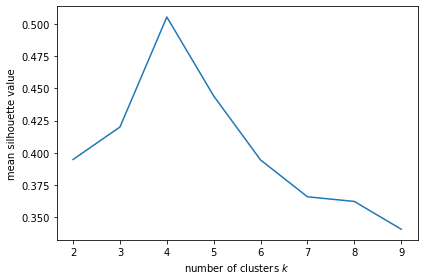

In [10]:
fig, ax = plt.subplots()
ax.plot( k_val, sil)
ax.set_ylabel('mean silhouette value')
ax.set_xlabel('number of clusters $k$')
fig.tight_layout()
fig.show()

The Silhouette Method agrees that 4 is the best choice for k.

__________
__________

# Customer Segmentation: the Recency-Frequency-Monetary (RFM) model


Customer segmentation is the practice of **dividing** a customer base into **groups of individuals** that are similar.
* We can use a number of attributes, such as age, gender, interests and spending habits.

**Recency-Frequency-Monetary (RFM)** analysis is a proven marketing model for behavior based customer segmentation, based on grouping customers based on their transaction history: 
   
   * *How recently* they bought something
   * *How often* they buy
   * *How much* they spend


More precisely, the RFM model combines three different customer attributes to rank customers.

1. **Recency:** time since the customer made his/her most recent purchase.

2. **Frequency:** number of purchases this customer made within a designated time period.

3. **Monetary:** total money spent.

We combine these three scores to create the RFM score, that can be used to segment our customers into different groups.

 


## **Case Study: Online Retail Store**

* Dataset - https://archive.ics.uci.edu/ml/datasets/online+retail

### About the dataset 

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

**Dataset Description**

* **InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'C', it indicates a cancellation. 
* **StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. 
* **Description:** Product (item) name. Nominal. 
* **Quantity:** The quantities of each product (item) per transaction. Numeric. 
* **InvoiceDate:** Invice Date and time. Numeric, the day and time when each transaction was generated. 
* **UnitPrice:** Unit price. Numeric, Product price per unit in sterling. 
* **CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. 
* **Country:** Country name. Nominal, the name of the country where each customer resides.

*Nominal:* a type of data that is used to label variables without providing any quantitative value.

In [11]:
# We load the dataset

df = pd.read_csv("Online_Retail.csv")
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [12]:
# We check the number of rows and columns

df.shape

(541909, 8)

In [13]:
# We know that if the InvoiceNo code starts with letter 'C', 
# it indicates a cancellation.
#
# We remove all transactions that have been cancelled
#

df = df[ ~df['InvoiceNo'].str.startswith('C') ]

In [14]:
# We have two numeric columns: Quantity and Unit Price.

df[['Quantity','UnitPrice']].describe()

Quantity      UnitPrice
count  532621.000000  532621.000000
mean       10.239972       3.847621
std       159.593551      41.758023
min     -9600.000000  -11062.060000
25%         1.000000       1.250000
50%         3.000000       2.080000
75%        10.000000       4.130000
max     80995.000000   13541.330000

The *Quantity* and *Unit Price* columns include negative values, let us try do understand from the description what is the content of these rows.

In [15]:
# the & is the logical elementwise AND; the ~ is the logical elementwise NOT
df[ (df['Quantity'] < 0) & (~df['Description'].isnull()) ]

InvoiceNo StockCode Description  Quantity          InvoiceDate  \
7313      537032     21275           ?       -30  2010-12-03 16:50:00   
13217     537425    84968F       check       -20  2010-12-06 15:35:00   
13218     537426    84968E       check       -35  2010-12-06 15:36:00   
13264     537432    35833G     damages       -43  2010-12-06 16:10:00   
21338     538072     22423      faulty       -13  2010-12-09 14:10:00   
...          ...       ...         ...       ...                  ...   
535333    581210     23395       check       -26  2011-12-07 18:36:00   
535335    581212     22578        lost     -1050  2011-12-07 18:38:00   
535336    581213     22576       check       -30  2011-12-07 18:38:00   
536908    581226     23090     missing      -338  2011-12-08 09:56:00   
538919    581422     23169     smashed      -235  2011-12-08 15:24:00   

        UnitPrice  CustomerID         Country  
7313          0.0         NaN  United Kingdom  
13217         0.0         NaN  United Kingdom  
13218         0.0         NaN  United Kingdom  
13264         0.0         NaN  United Kingdom  
21338         0.0         NaN  United Kingdom  
...           ...         ...             ...  
535333        0.0         NaN  United Kingdom  
535335        0.0         NaN  United Kingdom  
535336        0.0         NaN  United Kingdom  
536908        0.0         NaN  United Kingdom  
538919        0.0         NaN  United Kingdom  

[474 rows x 8 columns]

In [16]:
df[ (df['UnitPrice'] < 0) & (~df['Description'].isnull()) ]

InvoiceNo StockCode      Description  Quantity          InvoiceDate  \
299983   A563186         B  Adjust bad debt         1  2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1  2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

It seems that the dataset includes lost, damaged and returned items, as well as rows that do not refer to an actual transaction.
* We are interested in transactions that describe customer purchases.
* We can remove these rows.

In [17]:
# We remove the transactions with a negative Quantity

df = df[ ~(df['Quantity']<0) ]

# We remove the transactions with a negative Unit Price

df = df[ ~(df['UnitPrice']<0) ]

### Data cleaning

As always, we first need a sanity check:
- missing values
- duplicates
- data types
- internal consistency

#### Missing values

In [18]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description       592
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133359
Country             0
dtype: int64

The dataframe contains transaction that miss the CustomerID and/or the Description.

* We want to cluster the customers, so the rows with no CustomerID are useless and we can drop them. 
* We can instead ignore the empty Descriptions.

In [19]:
df = df[~df['CustomerID'].isna()]

#### Duplicates

In [20]:
df.duplicated().sum()

5192

In [21]:
df = df.drop_duplicates()

# ** NOTE **
#
#  drop_duplicates()
# 
#   Return DataFrame with duplicate rows removed.
#
# ** NOTE **

#### Data types

In [22]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [23]:
# We convert the InvoiceDate to DateTime

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df = df.astype({'CustomerID': 'int64'})

In [24]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

#### Internal consistency

We expect each invoice to have a unique date, let's check the constraint InvoiceNo/InvoiceDate.

In [25]:
df[ df.groupby(["InvoiceNo"])["InvoiceDate"].transform('nunique').gt(1) ].sort_values(by=['InvoiceDate'])

InvoiceNo StockCode                          Description  Quantity  \
2421      536591     21427             SKULLS STORAGE BOX SMALL         1   
2440      536591     20768                  GREEN FERN JOURNAL          1   
2441      536591     22081           RIBBON REEL FLORA + FAUNA          1   
2442      536591     20780            BLACK EAR MUFF HEADPHONES         1   
2443      536591    51014C               FEATHER PEN,COAL BLACK        12   
...          ...       ...                                  ...       ...   
498962    578548     84347  ROTATING SILVER ANGELS T-LIGHT HLDR         2   
498963    578548     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS         2   
498952    578548    84673A                        PINK FLY SWAT         2   
498991    578548     84347  ROTATING SILVER ANGELS T-LIGHT HLDR         3   
498992    578548     22411    JUMBO SHOPPER VINTAGE RED PAISLEY         1   

               InvoiceDate  UnitPrice  CustomerID         Country  
2421   2010-12-01 16:57:00       2.10       14606  United Kingdom  
2440   2010-12-01 16:57:00       2.55       14606  United Kingdom  
2441   2010-12-01 16:57:00       1.65       14606  United Kingdom  
2442   2010-12-01 16:57:00       5.49       14606  United Kingdom  
2443   2010-12-01 16:57:00       0.85       14606  United Kingdom  
...                    ...        ...         ...             ...  
498962 2011-11-24 15:02:00       2.55       17345  United Kingdom  
498963 2011-11-24 15:02:00       7.95       17345  United Kingdom  
498952 2011-11-24 15:02:00       0.65       17345  United Kingdom  
498991 2011-11-24 15:03:00       2.55       17345  United Kingdom  
498992 2011-11-24 15:03:00       2.08       17345  United Kingdom  

[1586 rows x 8 columns]

At a first sight, it seems that the same invoice can contains different dates.

A closer inspection suggests that what actually changes is just the time.

Let us verify.

In [26]:
# We create a new column containing only the date.

df['Date'] = df["InvoiceDate"].dt.date
df['Date'] = pd.to_datetime(df['Date'])

# We check the constraint InvoiceNo/Date

df[ df.groupby(["InvoiceNo"])["Date"].transform('nunique').gt(1) ].sort_values(by=['Date'])

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Date]
Index: []

We also check that each InvoiceNo refers to a single CustomerID

In [27]:
# InvoiceNo/CustomerID constraint

df[ df.groupby(["InvoiceNo"])["CustomerID"].transform('nunique').gt(1) ]

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country, Date]
Index: []

### Exercise

Perform an Exploratory Data Analysis of the dataset:
* **Q1:** Top 10 ordering countries (number of orders).
* **Q2:** Number of unique customers.
* **Q3:** Check the constraint StockCode/Description.

In [28]:
# The code goes here!

### **RFM Dataframe**

To apply the RFM analysis we need the following information: *Recency*, *Frequency*, *Monetary*.

* **Q**: How do we extranct these information from our dataset?



In [29]:
# 1. We create a new column called 'TotalPrice'

df['TotalPrice'] = df['UnitPrice']*df['Quantity']

# 2. We remove the columns we do not need

df.drop(['StockCode','Description', 'Country', 'UnitPrice', 'Quantity', 'InvoiceDate'], axis=1, inplace=True)

df.head()

InvoiceNo  CustomerID       Date  TotalPrice
0    536365       17850 2010-12-01       15.30
1    536365       17850 2010-12-01       20.34
2    536365       17850 2010-12-01       22.00
3    536365       17850 2010-12-01       20.34
4    536365       17850 2010-12-01       20.34

In [30]:
# We can easily group data by 'InvoiceNo' and get the total for that invoice

df.groupby(['InvoiceNo'], as_index=False).agg({'Date': 'first', 'CustomerID': 'first', 'TotalPrice': 'sum'})

InvoiceNo       Date  CustomerID  TotalPrice
0        536365 2010-12-01       17850      139.12
1        536366 2010-12-01       17850       22.20
2        536367 2010-12-01       13047      278.73
3        536368 2010-12-01       13047       70.05
4        536369 2010-12-01       13047       17.85
...         ...        ...         ...         ...
18531    581583 2011-12-09       13777      124.60
18532    581584 2011-12-09       13777      140.64
18533    581585 2011-12-09       15804      329.05
18534    581586 2011-12-09       13113      339.20
18535    581587 2011-12-09       12680      249.45

[18536 rows x 4 columns]

#### **Recency**

**Q**: How many days ago was each customer's last purchase?

* We need to fix a reference date to compute how recent is the most recent transaction of each customer.

* We fix the reference date to a day after the most recent transaction date in the dataset.

In [31]:
# Reference date

refDate = df['Date'].max()
print(refDate)

refDate += pd.Timedelta("1 day")
print(refDate)

2011-12-09 00:00:00
2011-12-10 00:00:00


In [32]:
# We calculate the days difference between the most recent transaction 
# carried out by the customer and the reference date.

df['Recency'] = (refDate - df['Date']).dt.days

dfRFM = df.groupby("CustomerID", as_index=False).agg({'Recency' : 'min'})

dfRFM.head()

CustomerID  Recency
0       12346      326
1       12347        3
2       12348       76
3       12349       19
4       12350      311

#### **Frequency**

**Q**: How many purchases did each customer make?

In [33]:
# We count the number of orders made by each customer

F = df[['CustomerID', 'InvoiceNo']].groupby('CustomerID', as_index=False).count()
F.rename(columns={'InvoiceNo': 'Frequency'}, inplace= True)

F.head()

CustomerID  Frequency
0       12346          1
1       12347        182
2       12348         31
3       12349         73
4       12350         17

In [34]:
# We merge the two dataframe

dfRFM = dfRFM.merge(F)

# ** NOTE **
#
#  merge()
# 
#    Merge DataFrame or named Series objects with a database-style join.
#    A named Series object is treated as a DataFrame with a single named column.
#
# ** NOTE **

dfRFM.head()

CustomerID  Recency  Frequency
0       12346      326          1
1       12347        3        182
2       12348       76         31
3       12349       19         73
4       12350      311         17

#### **Monetary**

**Q:** How much did customers spend for their purchases?

In [35]:
# We compute the total amount spent by each customer

M = df[['CustomerID', 'TotalPrice']].groupby('CustomerID', as_index=False).sum()
M.rename(columns={'TotalPrice': 'Monetary'}, inplace= True)

M.head()

CustomerID  Monetary
0       12346  77183.60
1       12347   4310.00
2       12348   1797.24
3       12349   1757.55
4       12350    334.40

In [36]:
# We merge the two dataframe

dfRFM = dfRFM.merge(M)

dfRFM.head()

CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12347        3        182   4310.00
2       12348       76         31   1797.24
3       12349       19         73   1757.55
4       12350      311         17    334.40

### K-means clustering

To perform customer segmentation, we apply the k-means clustering algorithm to the RFM dataframe. 

Before applying the algorithm:

* We check for outliers

  * We look for outliers from the data analysis point of view. These are transactions that are valid from the business point of view as they are genuine transaction records. 

* We standardize our data







#### **Outliers**

An outlier is a point or set of data points that lie away from the rest of the data values of the dataset. 

* An outlier is a data point(s) that appear away from the overall distribution of data values in a datase.

**Q1:** How do we check if our data contain outliers?


<ipython-input-37-989edda0c82b>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


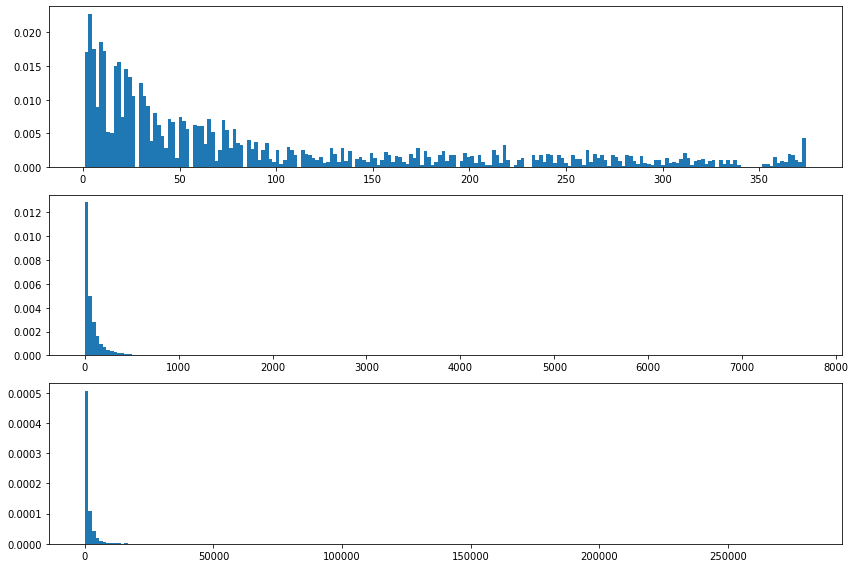

In [37]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

nBins = 200
ax1.hist( dfRFM['Recency'],   nBins,  density=True)
ax2.hist( dfRFM['Frequency'], nBins,  density=True)
ax3.hist( dfRFM['Monetary'],  nBins,  density=True)

fig.tight_layout()
fig.show()

<ipython-input-38-978721c10cf5>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


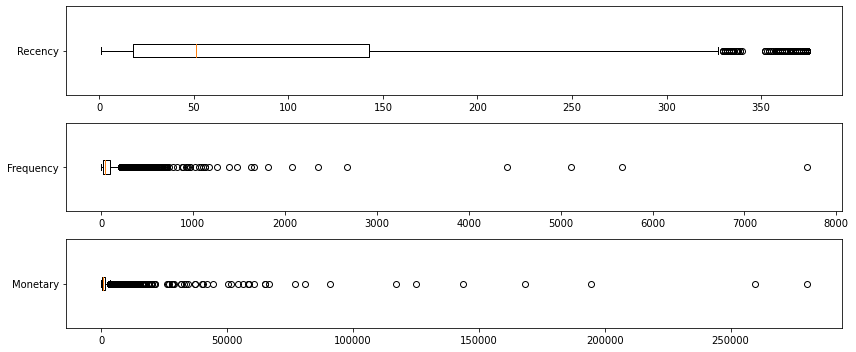

In [38]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 5))

ax1.boxplot( dfRFM['Recency'],    vert=False, labels=['Recency']   )
ax2.boxplot( dfRFM['Frequency'],  vert=False, labels=['Frequency'] )
ax3.boxplot( dfRFM['Monetary'],   vert=False, labels=['Monetary']  )

fig.tight_layout()
fig.show()

We observe for all features that several data points, on the right side of the distribution, are marked as outliers.

* In the box plot all points greater than Q3+1.5*IQR are considered outliers.

**Q2:** How do we treat outliers? 

In this case:

* Recency outliers are not so different from other customers in the tail of the distribution -> We keep them.
* Frequency and Monetary outliers are customers that buy a *lot* more often and spend a *lot* more than all others. We should probably treat them separately (as VIP customers) -> We trim them as well (for the scope of this analysis)



In [39]:
import numpy as np

RFM_col = ['Frequency', 'Monetary']

trRFM = dfRFM.copy()

right_whisker = {}
for c in RFM_col:
    Q1 = trRFM[c].quantile(0.25)
    Q3 = trRFM[c].quantile(0.75)
    IQR = Q3 - Q1
    right_whisker[c] = (Q3+1.5*IQR)
    
trRFM = trRFM[(trRFM['Frequency']<=right_whisker['Frequency'])&(trRFM['Monetary']<=right_whisker['Monetary'])]
trRFM.reset_index(inplace=True, drop=True)

trRFM.head()

CustomerID  Recency  Frequency  Monetary
0       12348       76         31   1797.24
1       12349       19         73   1757.55
2       12350      311         17    334.40
3       12352       37         85   2506.04
4       12353      205          4     89.00

We plot our new dataframe

<ipython-input-40-fcaaafde9c88>:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


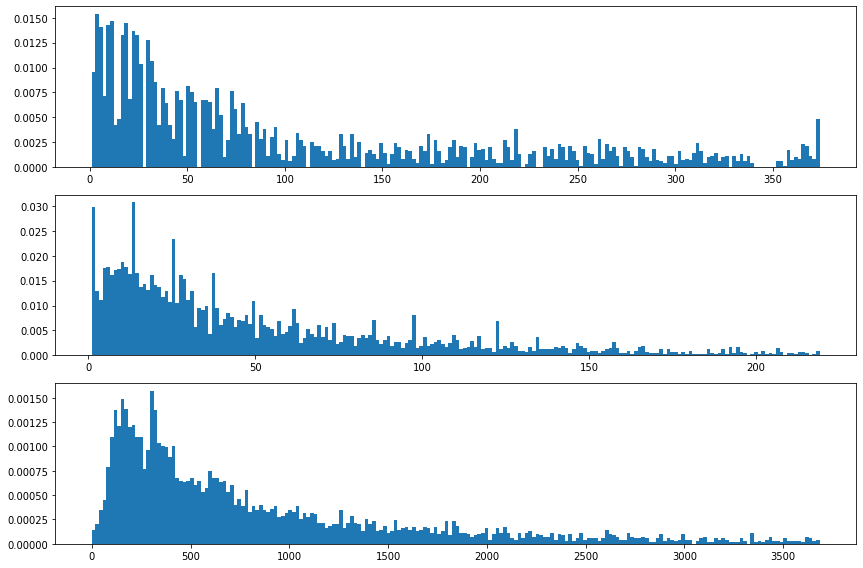

In [40]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

nBins = 200
ax1.hist( trRFM['Recency'],   nBins,  density=True)
ax2.hist( trRFM['Frequency'], nBins,  density=True)
ax3.hist( trRFM['Monetary'],  nBins,  density=True)

fig.tight_layout()
fig.show()

We can even try a 3D plot:

<ipython-input-41-54c024a76f26>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


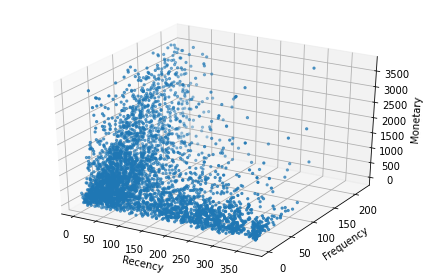

In [41]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.scatter(trRFM['Recency'], trRFM['Frequency'], trRFM['Monetary'], s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

fig.tight_layout()
fig.show()

**Q3:** Why is it important to look for outliers?

Spatial clustering algorithms are generally **very sensitive** to outliers and to incomparable scales or magnitudes, especially those, like *k-means* that have a predetermined number of clusters:
- outliers, being far away from the rest, are clustered by their own, pushing all other data points together
- differences in scale make some of the features more relavant when computing distances


### Standardization

In [42]:
trRFM['zR'] = ( trRFM['Recency'] - trRFM['Recency'].mean()) / trRFM['Recency'].std()
trRFM['zF'] = ( trRFM['Frequency'] - trRFM['Frequency'].mean()) / trRFM['Frequency'].std()
trRFM['zM'] = ( trRFM['Monetary'] - trRFM['Monetary'].mean()) / trRFM['Monetary'].std()

trRFM.head()

CustomerID  Recency  Frequency  Monetary        zR        zF        zM
0       12348       76         31   1797.24 -0.267031 -0.400123  1.242209
1       12349       19         73   1757.55 -0.824177  0.502092  1.191319
2       12350      311         17    334.40  2.029971 -0.700861 -0.633457
3       12352       37         85   2506.04 -0.648236  0.759868  2.151039
4       12353      205          4     89.00  0.993876 -0.980118 -0.948111


### Choice of K

As in the toy example, we try both the **Elbow Method** and the **Silhouette Method**

#### **The Elbow Method**

In [43]:
cols = ['zR','zF','zM']

def distance (v, w):
    return math.sqrt( sum([ (v_i-w_i)**2 for v_i, w_i in zip(v,w) ]) )

k_val = list(range(1,10))
sse = []

for k in k_val:
    kmeans = cluster.KMeans(n_clusters=k, random_state=10).fit( trRFM [cols] )
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(trRFM [cols])
    k_sse = 0

    for i in range(trRFM.shape[0]):
        center = centroids[pred_clusters[i]]
        point = [ trRFM['zR'][i], trRFM['zF'][i], trRFM['zM'][i]   ]
        k_sse += distance( point, center)

    sse.append(k_sse)

# ** NOTE **
#
#  cluster_centers_ : ndarray of shape (n_clusters, n_features)
#    Coordinates of cluster centers.
#
#  labels_ : ndarray of shape (n_samples,)
#    Labels of each point 
#
# ** NOTE **

#trRFM.head()


<ipython-input-44-8483e6850922>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


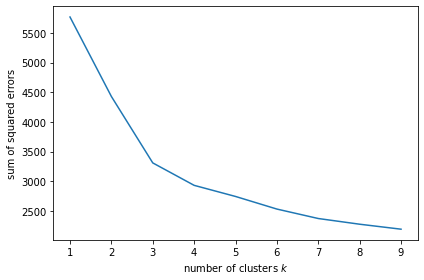

In [44]:
fig, ax = plt.subplots()
ax.plot( k_val, sse)
ax.set_ylabel('sum of squared errors')
ax.set_xlabel('number of clusters $k$')
fig.tight_layout()
fig.show()

The Elbow Method suggests that 3 is the 'right' number of clusters, the main bend in the chart is at $k=3$.

#### **The Silhouette Method**

In [45]:
from sklearn.metrics import silhouette_score

k_val = list(range(2,10))
sil = []

for k in k_val:
    kmeans = cluster.KMeans(n_clusters=k, random_state=10).fit( trRFM [cols] )
    labels = kmeans.labels_
    sil.append(silhouette_score(trRFM [cols], labels))


In [46]:
fig, ax = plt.subplots()
ax.plot( k_val, sil)
ax.set_ylabel('average silhouette value')
ax.set_xlabel('number of clusters $k$')
fig.tight_layout()
fig.show()

<ipython-input-46-f11d8b4d8191>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


The Silhouette Method suggests that both 3 and 5 could be good choices for k.

* We can have a better idea of the silhouette values of all points by plotting them.

* We plot all silhouette values for $k=3$ and $k=5$.

In [47]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


cluster_centers = dict()
k_val = [3,5]

for k in k_val:
    fig, ax = plt.subplots()
    # The silhouette coefficient can range from -1, 1,
    # but we do not have values less than -0.2
    ax.set_xlim([-0.2, 1])
    # The (k+1)*100 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, trRFM.shape[0] + (k + 1) * 100])

    kmeans = cluster.KMeans(n_clusters=k, random_state=10).fit( trRFM [cols] )
    labels = kmeans.labels_
    silhouette_avg = silhouette_score(trRFM [cols], labels)
    print(f"For k = {k} the average silhouette_score is : {silhouette_avg}")
    cluster_centers.update( { k : {
                                        'center':kmeans.cluster_centers_,
                                        'silhouette_avg':silhouette_avg,
                                        'labels':labels}
                           })

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(trRFM [cols], labels)

    y_lower = 100
    for i in range(k):
        # Select only value belonging to cluster i
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        # Sort them
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # We create a list of k colors from the color map nipy_spectral
        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
        )

# ** NOTE **
# 
#  fill_between(y, x1, x2, ... )
#
#    Fill the area between two vertical curves.
#    The curves are defined by the points (y, x1) and (y, x2). 
#    This creates one or multiple polygons describing the filled area.
#
#  arange() 
#
#    Return evenly spaced values within a given interval
#
# ** NOTE **

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 100  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


For k = 3 the average silhouette_score is : 0.449333540033897
For k = 5 the average silhouette_score is : 0.40901704757008944


### **Labeling Clusters**

We de-standardize the center of each cluster, to understand what is the profile of the customers inside each of them.

In [48]:
k_val = [3,5]
cols = ['Recency','Frequency','Monetary']
dfDic = {'Recency':[],'Frequency':[],'Monetary':[], 'Cluster':[] , 'k':[]}

for k in k_val:
    center = cluster_centers[k]['center']
    for ce in range(k):
        dfDic['k'].append(k)
        dfDic['Cluster'].append(ce)
        for i,co in enumerate(cols):      
            dfDic[co].append(trRFM[co].std()*center[ce][i]+trRFM[co].mean())

dfClusters = pd.DataFrame(dfDic)
dfClusters

Recency   Frequency     Monetary  Cluster  k
0   53.838903   35.055362   591.492795        0  3
1   43.548750  119.711250  1978.264039        1  3
2  256.469792   21.655208   365.111406        2  3
3   57.054091   25.645030   406.624350        0  5
4   41.226519  130.607735  2631.633925        1  5
5  259.502703   21.120000   357.833362        2  5
6   51.482270   60.890780  1376.148553        3  5
7   45.425170  133.234694   897.386905        4  5

In [49]:
dfClusters[ dfClusters['k'] == 3]

Recency   Frequency     Monetary  Cluster  k
0   53.838903   35.055362   591.492795        0  3
1   43.548750  119.711250  1978.264039        1  3
2  256.469792   21.655208   365.111406        2  3

#### **Three Clusters (Customer Segments):** 

* **High value customer:** Customers in *cluster 1* place orders with the highest value at a very high relative frequency compared to other customers. They are also the ones who placed an order the most recently.

* **Medium value customer:** Customers in *cluster 0* place orders of considerable amount, though not comparable to customers in *cluster 1*. Their orders are relative more frequent than those placed by customers in *cluster 2* and slightly less recent that customers in *cluster 1*. 

* **Low value customer:** Customers in *cluster 2* rarely shop and when they order, their orders are pretty low valued. They placed their last order a long time ago. Customers in this cluster could be at risk.


In [50]:
dfClusters[ dfClusters['k'] == 5].sort_values(by=['Monetary','Frequency','Recency'])

Recency   Frequency     Monetary  Cluster  k
5  259.502703   21.120000   357.833362        2  5
3   57.054091   25.645030   406.624350        0  5
7   45.425170  133.234694   897.386905        4  5
6   51.482270   60.890780  1376.148553        3  5
4   41.226519  130.607735  2631.633925        1  5

#### **Five Clusters (Customer Segments):** 

* **Top customer:** Customers in *cluster 1* are high value customer who has shopped recently and shops regularly for high value orders.

* **High value customer:** Customers in *cluster 3* place quite high value orders but do not do so frequently or have not done it much recently. 

* **Medium value customer:** Customers in *cluster 4* have recently placed medium valued orders. Consumers in this group have the highest frequency. In the long-term view, some of these consumers might become very highly profitable. 

* **Low value customers:** Customers in *cluster 0* placed medium valued orders quite a long time ago and they do not order very frequently.
 
* **Lost Customers:** Customers in *cluster 2* have not shopped in the longest time, nor do they shop frequently and their orders are of the lowest values. The low value of frequency and the high value of recency are signals that these customers are at risk or we have already lost them.


#### **Exercise**

* **Q1:** What is the size of each cluster?

* **Q2:** What percentage of the total sales do the customers in the most valuable cluster represent?
  * **Q2.1:** What is the sales percentage of each cluster?
  
  
* **Q3:** How does the result of our analysis change if: we cap our data instead of trimming them, we apply the percentile approach to identify outliers, we keep all outliers without *treating* them? 

### **Clustering (percentiles)**

We can use other methods to cluster our customers, a common approach is to use percentiles.

* RFM analysis involves scoring and ranking customers according to three attributes separately.

* A common approach is to have five grades for each attribute, yielding a total of 125 combinations.

  * We assign a score from one to five to recency, frequency and monetary values individually for each customer. 
  
  * Five is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.
  
    * Customers who purchased recently, are frequent buyers and spend a lot are assigned score of 555 – Recency(R) – 5, Frequency(F) – 5, Monetary(M) – 5. They are your best customers.

    * Customers spending the lowest, making hardly any purchase and that too a long time ago are assigned score of 555. Recency(R) – 1, Frequency(F) – 1, Monetary(M) – 1. 




#### **Quintiles**

We use quintiles that are the 20th, 40th, 60th and 80th percentiles, thus dividing the data in 5 equal parts.

In [51]:
# We compute the RFM score of each customer

dfRFM["R"] = pd.qcut( dfRFM["Recency"],    5,  labels=[5,4,3,2,1] )
dfRFM["F"] = pd.qcut( dfRFM["Frequency"],  5,  labels=[1,2,3,4,5] )
dfRFM["M"] = pd.qcut( dfRFM["Monetary"],   5,  labels=[1,2,3,4,5] )

# ** NOTE **
# 
#  qcut(x, q, labels=None, ...)
#
#    Quantile-based discretization function.
#    Discretize variable into equal-sized buckets based on rank 
#    or based on sample quantiles. 
# 
#    x: 1d ndarray or Series
#
#    q: int or list-like of float
#      Number of quantiles. 10 for deciles, 4 for quartiles, etc. 
#      Alternately array of quantiles, e.g. [0, .25, .5, .75, 1.] for quartiles.
#
#    labels: array or False, default None
#      Used as labels for the resulting bins. Must be of the same length 
#      as the resulting bins. If False, return only integer indicators of 
#      the bins. If True, raises an error. 
#
# ** NOTE **

dfRFM["RFM_Score"] = dfRFM["R"].astype(str) + dfRFM["F"].astype(str) + dfRFM["M"].astype(str)

dfRFM

CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Score
0          12346      326          1  77183.60  1  1  5       115
1          12347        3        182   4310.00  5  5  5       555
2          12348       76         31   1797.24  2  3  4       234
3          12349       19         73   1757.55  4  4  4       444
4          12350      311         17    334.40  1  2  2       122
...          ...      ...        ...       ... .. .. ..       ...
4334       18280      278         10    180.60  1  1  1       111
4335       18281      181          7     80.82  1  1  1       111
4336       18282        8         12    178.05  5  1  1       511
4337       18283        4        721   2045.53  5  5  4       554
4338       18287       43         70   1837.28  3  4  4       344

[4339 rows x 8 columns]

### **Exercise**

* **Q1:** What is the maximum number of clusters that this method creates?

* **Q2:** How many clusters did we create?

* **Q3:** How many customers do we have inside each cluster?

* **Q4:** Which are the most populated clusters (top10)?

### **Labeling**

* **Q1:** How do we label our clusters?

We propose the following labeling with 7 clusters. 

* We treat Frequency and Monetary as a single combined value (dimension).

| Label |	Description |	R | F+M |
| --- | --- | --- | --- | 
| Champions | Bought recently, buy often and spend a good amount. | 5 | 9-10 |
| Loyal | Buy often from our store and spend a good amount.<br> Customers who have the most potential to become the Champions. | 3-4 | 8-10 |
| Recent | Bought recently, but not often or for a small amount amount. | 4<br>5 | 2-7<br>2-8 |
| Needing Attention | Above average recency or frequency or monetary values.  |2<br>3 |8-10<br>2-7 |
| About to sleep | Below average recency, frequency and monetary value. | 2| 2-7 |
| Can't lose them| Made big purchases, and often. They have not returned for a long time.|1| 8-10 |
|Hibernating|Last purchase was long back, low spenders and low number of orders|1|2-7|

In [52]:
# We apply our labels to our dataset

dfRFM['Label'] = [np.nan]*dfRFM.shape[0]

dfRFM.loc[ (dfRFM['R'].astype(int) == 5) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) >= 9 ), 'Label'] = "Champions"

dfRFM.loc[ (dfRFM['R'].astype(int) == 4) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) >= 8 ), 'Label'] = "Loyal"
dfRFM.loc[ (dfRFM['R'].astype(int) == 3) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) >= 8 ), 'Label'] = "Loyal"

dfRFM.loc[ (dfRFM['R'].astype(int) == 5) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) <= 8 ), 'Label'] = "Recent"
dfRFM.loc[ (dfRFM['R'].astype(int) == 4) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) <= 7 ), 'Label'] = "Recent"

dfRFM.loc[ (dfRFM['R'].astype(int) == 2) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) >= 8 ), 'Label'] = "Needing Attention"
dfRFM.loc[ (dfRFM['R'].astype(int) == 3) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) <= 7 ), 'Label'] = "Needing Attention"

dfRFM.loc[ (dfRFM['R'].astype(int) == 2) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) <= 7 ), 'Label'] = "About to Sleep"

dfRFM.loc[ (dfRFM['R'].astype(int) == 1) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) >= 8 ), 'Label'] = "Can't Lose Them"

dfRFM.loc[ (dfRFM['R'].astype(int) == 1) & ((dfRFM["F"].astype(int)+dfRFM["F"].astype(int)) <= 7 ), 'Label'] = "Hibernationg"

dfRFM



CustomerID  Recency  Frequency  Monetary  R  F  M RFM_Score  \
0          12346      326          1  77183.60  1  1  5       115   
1          12347        3        182   4310.00  5  5  5       555   
2          12348       76         31   1797.24  2  3  4       234   
3          12349       19         73   1757.55  4  4  4       444   
4          12350      311         17    334.40  1  2  2       122   
...          ...      ...        ...       ... .. .. ..       ...   
4334       18280      278         10    180.60  1  1  1       111   
4335       18281      181          7     80.82  1  1  1       111   
4336       18282        8         12    178.05  5  1  1       511   
4337       18283        4        721   2045.53  5  5  4       554   
4338       18287       43         70   1837.28  3  4  4       344   

               Label  
0       Hibernationg  
1          Champions  
2     About to Sleep  
3              Loyal  
4       Hibernationg  
...              ...  
4334    Hibernationg  
4335    Hibernationg  
4336          Recent  
4337       Champions  
4338           Loyal  

[4339 rows x 9 columns]

<ipython-input-53-2a85275021f0>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


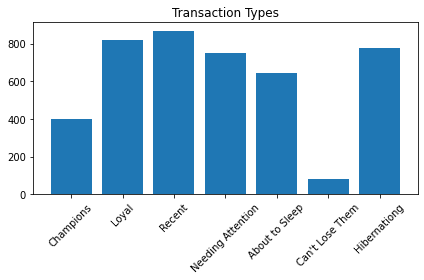

In [53]:
fig, ax = plt.subplots()

pltRFM = dfRFM.groupby('Label', as_index=False).aggregate({'CustomerID':'nunique'})

# setting the order for the plot, from top customers to low-value customers
labels_order = {l:i for i,l in enumerate(['Champions', 'Loyal', 'Recent', 'Needing Attention', 'About to Sleep', "Can't Lose Them", 'Hibernating'])}
pltRFM.sort_values(by="Label", key=lambda x:x.map(labels_order), inplace=True)

ax.bar(x=pltRFM['Label'], height=pltRFM["CustomerID"])
ax.set_title("Transaction Types") # Add a title to the axes.
ax.tick_params(axis='x', labelrotation=45)
fig.tight_layout()
fig.show()

________
________


# **Recommender Systems**

A common problem in marketing-oriented data analysis is producing recommendations of some sort. 

* Netflix recommends movies you might want to watch. 

* Amazon recommends products you might want to buy. 

* Twitter recommends users you might want to follow. 

**Q1:** How do we suggest new interests or products to our customers?

**Q2:** How can we build a recommender system?



## A toy example

Let us go back to the user interests toy dataset.


In [54]:
# Our data set is a python list containing users interests.
# Each element of the list contains the interests of a specific user.

users_interests = [
        ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
        ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
        ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
        ["R", "Python", "statistics", "regression", "probability"],
        ["machine learning", "regression", "decision trees", "libsvm"],
        ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
        ["statistics", "probability", "mathematics", "theory"],
        ["machine learning", "scikit-learn", "Mahout", "neural networks"],
        ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
        ["Hadoop", "Java", "MapReduce", "Big Data"],
        ["statistics", "R", "statsmodels"],
        ["C++", "deep learning", "artificial intelligence", "probability"],
        ["pandas", "R", "Python"],
        ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
        ["libsvm", "regression", "support vector machines"]
]

### Approach 1: recommending what’s popular

One easy approach is to simply recommend what’s popular. 

* We do not take into account the current specified interests of the user.
* We do filter current user's interests before suggesting new interests.
* Popularity based recommendations can be a good strategy for targeting new customers, those for whom we do not have a history of interests.




**Q1:** How do we recommend popular interests?

In [55]:
from collections import Counter

# We count how many times each interest has been selected by users.
# We order them from the most common to the least common.

popular_interests = Counter(interest for user_interests in users_interests for interest in user_interests).most_common()

# ** NOTE **
#
# A Counter is a dict subclass for counting hashable objects. 
# It is a collection where elements are stored as dictionary 
# keys and their counts are stored as dictionary values. 
# Counts are allowed to be any integer value including zero or 
# negative counts.
# 
# Counter([iterable-or-mapping])
#   Counter iterates over the input elements and produces a 
#   dictionary with the elements as keys and their frequency 
#   as values. 
#
# most_common([n])
#   Return a list of the n most common elements and their 
#   counts from the most common to the least common.
#
# ** NOTE **

popular_interests[:5]

[('Python', 4), ('R', 4), ('Big Data', 3), ('HBase', 3), ('Java', 3)]

At least, we suggest to the users the most popular interests *that they are not already interested in*.

To this end, we write a function that takes as input the user's interests and returns as output the recommendations.

In [56]:
# The function takes as input a list of user's interests and
# return a list of suggestion of length <max_results>

def most_popular_new_interests(user_interests, max_results=5): 
    suggestions = [(interest, frequency) 
                    for interest, frequency in popular_interests
                    if interest not in user_interests ] 
  
    return suggestions[:max_results]

In [57]:
# We make recommendations for user 0

print(f"User's interests: {users_interests[0]}\n")
print(f"Suggestions:")
most_popular_new_interests(users_interests[0], 5)

User's interests: ['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']

Suggestions:


[('Python', 4),
 ('R', 4),
 ('statistics', 3),
 ('regression', 3),
 ('probability', 3)]

### Approach 2: User-Based Collaborative Filtering

We want to recommend new interests to users based on their currently specified interests.

One way of taking a user’s interests into account is to look for users who are somehow ***similar*** to them, and then suggest the things that those users are interested in.

In **User-Based Collaborative Filtering**:
- **users** are defined by their **lists of interests**
- **similarity between users** means **similarity between interest lists**
- we recommend interests that are **popular among similar users**

**Q1:** More precisely, how do we represent users?

- We use **one-hot vectors**.

**Q2:** More precisely, how do we mesure **similarity**?

- We use the ***cosine similarity***.

We define the cosine similarity:

In [58]:
import math

def dot(a, b):
    return sum(a_i * b_i for a_i, b_i in zip(a, b))

def cosine_similarity(a, b):
    return dot(a, b) / math.sqrt(dot(a, a) * dot(b, b))

We compute the user vectors (see Lecture2):

In [59]:
# get all possible interests
unique_interests = sorted(set.union(*[set(interests) for interests in users_interests]))

# build dictionary of columns
d = {c:[] for c in unique_interests}
for user in users_interests:
    for c in unique_interests:
        if c in user:
            d[c].append(1)
        else:
            d[c].append(0)

# transform in a dataframe
users_df = pd.DataFrame(d)

# extract all vectors as a #users x #interests matrix
users_array = users_df.to_numpy()

We compute the pairwise similarity, as a #users $\times$ #users matrix:

In [60]:
from sklearn.metrics import pairwise_distances

sim_mat = pairwise_distances(users_array, metric=cosine_similarity)

#### **Recommendations**

**Q:** How do we use pairwise similarities to make recommendations for user $u$?

- We find the $m$ most similar users $v_1,\ldots,v_m$ to $u$ (if we want to consider all users, we set $m=\mathrm{\#users}$)
- For each interest $I$:
    - otherwise, we assign to $I$ a score equal to the sum of the similarity between $u$ and all users $v_k$ that have interest $I$
- We suggest to $u$ the interests based on this score, i.e., based on the **total similarity** of similar users that have those interests.

In [61]:
from collections import defaultdict

def user_based_suggestions(user_id, users_interests, sim_matrix, n_other_users=10, include_current_interests=False): 
    # empty dict, where each value is automatically initialized to 0.0
    suggestions = defaultdict(float)
    
    # sort other users by similarity with 
    most_similar = sim_matrix[user_id].argsort()[::-1]
    
    # ignore the user himself
    most_similar = most_similar[1:]
    
    # consider only the most similar users
    if n_other_users<len(most_similar):
        most_similar = most_similar[:n_other_users]
        
    # we only consider interests of the most similar users
    # each such interest has a score equal to the sum of the similarities of those users (if they have that interest)
    for v in most_similar:
        for interest in users_interests[v]:
            suggestions[interest] += sim_matrix[user_id][v]

    # possibly, exclude interests that the user already has
    if not include_current_interests:
        for interest in users_interests[user_id]:
            if interest in suggestions:
                del(suggestions[interest])
            
    # sort the suggestion by total score
    suggestions = sorted(suggestions.items(), key=lambda s: s[1], reverse=True)  

    return suggestions
    


We are ready to suggest new interests to our users.

In [62]:
# Let's see what we suggest to user 0

user_based_suggestions(0, users_interests, sim_mat)[:5]

[('MapReduce', 0.5669467095138409),
 ('MongoDB', 0.50709255283711),
 ('Postgres', 0.50709255283711),
 ('NoSQL', 0.3380617018914066),
 ('neural networks', 0.1889822365046136)]

### Approach 3: Item-Based Collaborative Filtering

We want to recommend new interests to users based on their currently specified interests.

Another way of taking a user’s interests into account is to suggest new interests that are somehow ***similar*** to the interests the user already has.

In **Item-Based Collaborative Filtering**:
- **items** are defined by the **users interested in them**
- **similarity between items** means **similarity between lists of users**
- we recommend **interests that are overall similar** to the user's interests

**Q1:** More precisely, how do we represent items?

- Again, we use **one-hot vectors**.

**Q2:** More precisely, how do we mesure **similarity**?

- Again, we use the ***cosine similarity***.


#### Interest vectors

We need **interest vectors**, instead of users vectors.
The principle is the same:
- vectors have one entry for each user in the dataset
- entry $j$ is 1 if user $j$ has that interest, 0 otherwise

Actually, we can just **transpose** the user matrix we already built: the columns of the user matrix will be the rows of the interests matrix


In [63]:
interests_array = users_array.T

# Example
#
# interests_array[0] corresponds to users interested in Big Data.
# since the only users interested in Big Data are 0, 8, and 9, Big Data must be represented as:
#
#   [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0]
#

print(f"Interest: {unique_interests[0]}" )
print(f"row: {interests_array[0]}" )


Interest: Big Data
row: [1 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


#### Exercise:

Compute the `interests_array` from scratch, using an analogous procedure to the one we used to build the `users_array`.

We compute the pairwise similarity, as a #interests $\times$ #interests matrix:

Text(0.5, 1.0, 'interest similarity')

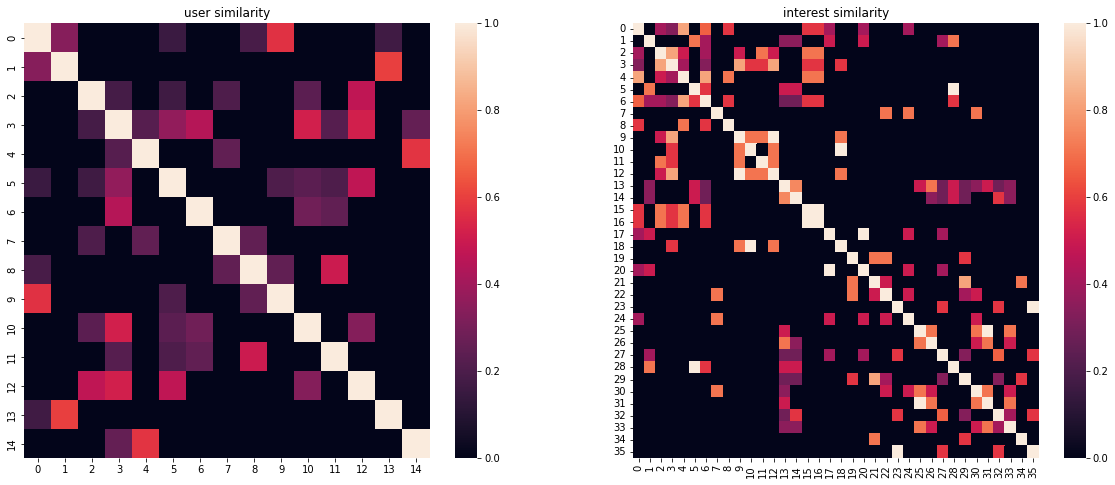

In [64]:
interests_sim_mat = pairwise_distances(interests_array, metric=cosine_similarity)


# let us compare the two similarity matrices
import seaborn as sns

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.heatmap(sim_mat, ax=ax1, )
ax1.set_title('user similarity')
sns.heatmap(interests_sim_mat, ax=ax2)
ax2.set_title('interest similarity')

#### **Recommendations**

**Q:** How do we use pairwise similarities to make recommendations for user $u$?

- For each item $I$ that $u$ is not already interested in:
    - we get the similarity of $I$ with all items $u$ is interested in
    - we assign to $I$ a score equal to the sum of such similarities
- we suggest to $u$ the interests having the maximum **total similarity score**

In [65]:
def item_based_suggestions(user_id, user_vector, interest_list, sim_matrix, include_current_interests=False): 
    
    # select only the similarity with respect to the user's interests
    # user_vector specifies that user's interests, i.e., which rows of sim_matrix we should consider
    sub_matrix = sim_matrix[user_vector.astype(bool)]
    # the sum of each column of the submatrix is the total similarity of each interest with that user's interests
    total_similarity = sub_matrix.sum(axis=0)
    
    # build a dictionary from interest names and total similarities
    suggestions = {interest:similarity for interest,similarity in zip(interest_list,total_similarity)}
    
    # possibly, exclude interests that the user already has
    if not include_current_interests:
        for i in range(len(interest_list)):
            if user_vector[i]>0 and interest_list[i] in suggestions:
                del(suggestions[interest_list[i]])

    # sort the suggestion by total score
    suggestions = sorted(suggestions.items(), key=lambda s: s[1], reverse=True)  

    return suggestions
    


We are ready to suggest new interests to our users.

In [66]:
# Let's see what we suggest to user 0

# the one-hot vector for user 0 is the 0th column of the interest array
user_vector = interests_array[:,0]

item_based_suggestions(0, user_vector, unique_interests, interests_sim_mat)[:5]

[('MapReduce', 1.861807319565799),
 ('MongoDB', 1.3164965809277263),
 ('Postgres', 1.3164965809277263),
 ('NoSQL', 1.2844570503761732),
 ('Haskell', 0.5773502691896258)]

_______
_______

## **Case Study: Amazon - Ratings (Beauty Products)**

You can find the data set [here](https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings). 

#### About the dataset

This is a dataset related to over 2 Million customer reviews and ratings of Beauty related products sold on their website.

It contains

* the unique **UserId** (Customer Identification),
* the product **ASIN** (Amazon's unique product identification code for each product),
* **Ratings** (ranging from 1-5 based on customer satisfaction) and
* the **Timestamp** of the rating (in UNIX time)

If you want to know which are the products in the data set you can check this [website](https://amazon-asin.com)

In [67]:
import pandas as pd

amazon = pd.read_csv('ratings_Beauty.csv')
amazon = amazon.dropna()
amazon.head(10)

UserId   ProductId  Rating   Timestamp
0  A39HTATAQ9V7YF  0205616461     5.0  1369699200
1  A3JM6GV9MNOF9X  0558925278     3.0  1355443200
2  A1Z513UWSAAO0F  0558925278     5.0  1404691200
3  A1WMRR494NWEWV  0733001998     4.0  1382572800
4  A3IAAVS479H7M7  0737104473     1.0  1274227200
5   AKJHHD5VEH7VG  0762451459     5.0  1404518400
6  A1BG8QW55XHN6U  1304139212     5.0  1371945600
7  A22VW0P4VZHDE3  1304139220     5.0  1373068800
8  A3V3RE4132GKRO  130414089X     5.0  1401840000
9  A327B0I7CYTEJC  130414643X     4.0  1389052800

In [68]:
amazon.shape

(2023070, 4)

There are indeed over 2 Million customer reviews in the data set.

#### **Exercise**

**Q1:** Count the number of unique users and products.

**Q2:** Check the constraint (UserId,ProductId)/Rating, each user can rate only once each product.

**Q3:** Count the number of ratings per user.


In [69]:
# The code goes here!

### **Product Popularity Based Recommendation**

We recommend what is popular.

* Approach 1: popular means high rating:  
    - sort products by average rating
* Approach 2: popular means many ratings:
    - sort products by number of ratings

#### Approach 1: high rating

In [70]:
avg_rating_products = amazon.groupby('ProductId', as_index=False)['Rating'].mean()

avg_rating_products.head(5)

ProductId  Rating
0  0205616461     5.0
1  0558925278     4.0
2  0733001998     4.0
3  0737104473     1.0
4  0762451459     5.0

In [71]:
# We sort products by average rating.
best_rated = avg_rating_products.sort_values('Rating', ascending=False)

# We suggest the most popular products.
best_rated.head(10)

ProductId  Rating
0       0205616461     5.0
135683  B00551HYQC     5.0
135663  B0054ZSIXC     5.0
135667  B00550UX52     5.0
135668  B00550YQP0     5.0
135673  B0055189P2     5.0
135678  B00551BAAI     5.0
135681  B00551EJWE     5.0
135685  B00551I2ZY     5.0
135707  B005535BC4     5.0

#### Approach 2: many ratings

In [72]:
number_ratings_products = amazon.groupby('ProductId', as_index=False).size()

number_ratings_products.head(5)

ProductId  size
0  0205616461     1
1  0558925278     2
2  0733001998     1
3  0737104473     1
4  0762451459     1

In [73]:
# We sort products by average rating.
most_rated = number_ratings_products.sort_values('size', ascending=False)

# We suggest the most popular products.
most_rated.head(10)

ProductId  size
65766   B001MA0QY2  7533
10516   B0009V1YR8  2869
110873  B0043OYFKU  2477
2365    B0000YUXI0  2143
105018  B003V265QW  2088
41474   B000ZMBSPE  2041
94769   B003BQ6QXK  1918
124659  B004OHQR1Q  1885
43368   B00121UVU0  1838
17629   B000FS05VG  1589

#### Exercise:

**Q1:** Write a function that takes as input a UserId and returns a list of recommended products, filtering outthe products already rated by that user.

**Q2:** Combine the two approaches to have the products first sorted by average rating and, when tied, by number of ratings received. 

In [74]:
# The code goes here!

### Item-Based or User-Based Filtering?

Which one should you use? The choice depends on the **number** of users and items:

* Item-based scales with the number of items, user-based scales with the number of users.
    - If you have a *lot* more users than items, item-based is probably preferrable
    - If you have a *lot* more items than users, user-based is probably preferrable
* In most product-driven recommendation engines, there are more people buying items than unique items for sale:
    - The number of users outnumbers the number of items and item-based is used

### Item-Based Collaborative Filtering

**Remark**: In the following, I will only use a subset of the original dataset, so that each step runs sufficiently fast to complete during the lecture. You might want to try using a larger sample (or even the entire dataset, if you have plenty of time) and see how the results change.

In [75]:
ratings = amazon.head(20000)

To create the product matrix, we use *pivoting*, which allows specifying what column you want as rows, columns and values.

In [76]:
prod_matrix = ratings.pivot_table(values='Rating', index='ProductId', columns='UserId', fill_value=0)
prod_matrix.head()

# ** NOTE **
#
# pivot_table()
#    Create a spreadsheet-style pivot table as a DataFrame.
#
# ** NOTE **

UserId      A00205921JHJK5X9LNP42  A00473363TJ8YSZ3YAGG9  \
ProductId                                                  
0205616461                      0                      0   
0558925278                      0                      0   
0733001998                      0                      0   
0737104473                      0                      0   
0762451459                      0                      0   

UserId      A01437583CZ7V02UKZQ5S  A020135981U0UNEAE4JV  \
ProductId                                                 
0205616461                      0                     0   
0558925278                      0                     0   
0733001998                      0                     0   
0737104473                      0                     0   
0762451459                      0                     0   

UserId      A024581134CV80ZBLIZTZ  A03056581JJIOL5FSKJY7  \
ProductId                                                  
0205616461                      0                      0   
0558925278                      0                      0   
0733001998                      0                      0   
0737104473                      0                      0   
0762451459                      0                      0   

UserId      A03099101ZRK4K607JVHH  A03454732N8VEYJAMGTTH  \
ProductId                                                  
0205616461                      0                      0   
0558925278                      0                      0   
0733001998                      0                      0   
0737104473                      0                      0   
0762451459                      0                      0   

UserId      A0505229A7NSH3FRXRR4  A05492663T95KW63BR75K  ...  AZYR51QTD6FAY  \
ProductId                                                ...                  
0205616461                     0                      0  ...              0   
0558925278                     0                      0  ...              0   
0733001998                     0                      0  ...              0   
0737104473                     0                      0  ...              0   
0762451459                     0                      0  ...              0   

UserId      AZZ5ENX41WOYZ  AZZ8A0TEQOD7J  AZZDA9BRMPP1B  AZZHB6U54UDYW  \
ProductId                                                                
0205616461              0              0              0              0   
0558925278              0              0              0              0   
0733001998              0              0              0              0   
0737104473              0              0              0              0   
0762451459              0              0              0              0   

UserId      AZZHJZP4GQPPZ  AZZNK89PXD006  AZZOFVMQC0BJG  AZZQXL8VDCFTV  \
ProductId                                                                
0205616461              0              0              0              0   
0558925278              0              0              0              0   
0733001998              0              0              0              0   
0737104473              0              0              0              0   
0762451459              0              0              0              0   

UserId      AZZTJQ7CQZUD8  
ProductId                  
0205616461              0  
0558925278              0  
0733001998              0  
0737104473              0  
0762451459              0  

[5 rows x 19101 columns]

The matrix we obtained is **sparse**: we filled all missing ratings with a 0 and the number of zeros **greatly** outnumbers the number of non-zeros.

Reminder: we only considered 20000 rows of the original dataset, so only 20000 elements of this pivot table will be non-zero.

In [77]:
print('dataframe shape:', prod_matrix.shape)
print('total size of the dataframe:', prod_matrix.shape[0]*prod_matrix.shape[1])

dataframe shape: (1398, 19101)
total size of the dataframe: 26703198


## The Dimensionality Problem

Let us temporarily suspend the analysis to focus on a more general proble:

* When the **dimensionality increases**, the volume of the space increases so fast that the available data become **sparse**.
* Organizing and searching data often relies on detecting areas where objects form **groups with similar properties**:
    - high-dimensional spaces are vast and points in high-dimensional spaces tend not to be close to one another;
    - when you have a lot of dimensions, the closest points are generally **not much closer than average**, which means that you might not be able to identify clusters;
    - conversely, in low-dimensional data sets, the closest points tend to be **much closer** than average.
* In summary, high dimensionalily prevents common data organization strategies from being efficient because **all objects appear to be sparse and dissimilar in many ways**.

 
### Dimensionality Reduction

We can use techniques to extract the **most important dimensions**, defined as those dimensions that capture **as much of the *variation* in the data as possible**.

The techniques tipically used for dimensionality reduction are:

*  Singular Value Decomposition (SVD)  

*  Principal Component Analysis (PCA)


#### Example

We reduce dimensions and create “latent features” internally every day. 

* What does being "cool" mean?
    - we cannot directly measure "how cool" someone is
    - we internally *map* or *reduce* several different patterns of behavior to the one dimension of "coolness" 
* "Coolness" is an example of a latent feature:
 - it is **unobserved** and **not measurable directly**
 - it is, in some sense, a **combination** of many observable features
 - we implicitly *weigh* in our mind those observables and reduce them to a single **principal feature**

### Singular Value Decomposition (SVD)

We will use SVD for our data set. 

* Assumptions:
    - few pieces of data contain most of the *information* in our dataset
    - the rest of the data is irrelevant and can be treated as *noise*

* Approach:
    - we **decompose** the original **sparse matrix** to put it a new form that is easier to work with

In SVD, the original matrix $M$ is decomposed into three matrices called $U$, $\Sigma$, and $V^T$:
 
$$M = U\Sigma V^T$$

where, if $M$ is $m\times n$, then $U$ will be $m\times m$, $\Sigma$ will be $m\times n$, and $V^T$ will be $n\times n$. 

* $\Sigma$ is a **diagonal** matrix, i.e., all elements outside the diagonal are 0; 
* the diagonal elements of $\Sigma$ are the **singular values** of the original matrix $M$, sorted from largest to smallest;
* to reduce the size of our original matrix, we only select the most relevent singular values in $\Sigma$.


<img src="img/SVD.png" alt="SVD" width="500"/>

The light gray areas show the original data, and the **dark gray** areas show the **only data** used in the **matrix approximation**.

### **How many dimensions?** 

You typically want to keep 90% of the **energy** expressed in the matrix. 
* To calculate the total energy, you add up all the squared singular values. 
* You keep adding squared singular values until you reach 90% of the total. 



In [78]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(prod_matrix.to_numpy(), n_components = min(prod_matrix.shape) )

# ** NOTE ** 
#
# randomized_svd()
#   Computes a truncated randomized SVD.
#
# ** NOTE ** 

# 
# We set -- n_components = min(prod_matrix.shape) -- because we do not know
# yet how many components/dimensions we want to keep. We keep all of them.
# Sigma is a diagonal matrix, it contains at most min(m,n) singolar values.
#

Sigma2=Sigma**2
print(f"Tot Energy: {sum(Sigma2)}")
print(f"90%: {sum(Sigma2)*0.9}")

#
# We use the following function to select the number of dimensions to keep
#

def get_number_of_dimensions_to_keep( S, max_d ):
    S2 = S**2
    energy_90 = sum(S2)*0.9
    for i in range(max_d):
        if sum(S2[:i]) >= energy_90:
            return i
    return max_d

n_comp = get_number_of_dimensions_to_keep(Sigma,prod_matrix.shape[0])
print(f"Number of components: {n_comp}")


Tot Energy: 382923.9999999998
90%: 344631.59999999986
Number of components: 405


We now compute the **approximated matrix** to be used for our recommender system.

In [79]:
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=n_comp)
de_matrix = SVD.fit_transform(prod_matrix)

print(f"Original matrix: {prod_matrix.shape}")
print(f"Approximation: {de_matrix.shape}")

Original matrix: (1398, 19101)
Approximation: (1398, 405)


One more reason to reduce the number of dimensions is to **visualize** your data.

[-1.11686839e-14  1.34282068e-14 -2.12129986e-16 ... -5.09725009e-11
 -5.23675840e-13 -2.14011121e-09]


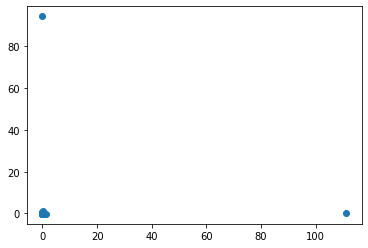

In [80]:
SVD_visual = TruncatedSVD(n_components=2)
visual_matrix = SVD_visual.fit_transform(prod_matrix)

print(visual_matrix[:,0])

import matplotlib.pyplot as plt

plt.scatter(visual_matrix[:,0],visual_matrix[:,1])

Do you like the result?

Not all algorithms for dimensionality reduction work in the same way, and the choice often depends on your goal:

In [ ]:
from sklearn.manifold import TSNE
TSNE_model = TSNE(n_components=2, init='random', perplexity=3)
visual_matrix = TSNE_model.fit_transform(prod_matrix)

print(visual_matrix.shape)

import matplotlib.pyplot as plt

plt.scatter(visual_matrix[:,0],visual_matrix[:,1])

## Back to the case study

We go back to the case study, with our new reduced matrix.

However, instead of using the cosine similarity, we now use **Pearson's correlation coefficient** as a measure of similarity between item vectors.

#### Exercise:

Repeat what follows using the Euclidean distance or the cosine similarity.

### Pearson's correlation

Pearson correlation is insensitive to the magnitude of users’ ratings. 

* Say one person rates everything with 5s, while another person rates everything with 1s. Pearson's correlation will capture the fact that these two users are both "constant raters" and score them as identical.

* Both Pearson's correlation and cosine similarity are invariant to scaling, i.e. multiplying all elements by a nonzero constant.
* Pearson's correlation, however, is also invariant with respect to **addition of a constant**:
    $$\rho_{X,Y} = \rho_{X,a*Y+b}$$
* In this case, this means that Pearson's correlation neglects "different standards":
    - a user giving 1,3,4 to 3 items is **equivalent** to a user giving 2,4,5 to the same items
    
**Remark**: be aware of the properties of the similarity measure you use!

In [ ]:
import numpy as np

# We compute the Pearson correlation between products pairs

corr_matrix = np.corrcoef(de_matrix)
corr_matrix.shape

# corr_matrix[i][j] contains the correlation between product i and product j


We can use the correlation matrix to list the products that are the most similar to a given product.

In [ ]:
# Given a product ID we can suggest new products

prod_ID = '602260074X'

# We need the index of the product to find it in the correlation matrix.

product_names = list(prod_matrix.index)
prod_idx = product_names.index(prod_ID)

print( f"Product ID: {prod_ID}, index: {prod_idx}")

# List of correlation values for product prod_ID whose index is prod_idx
                           
corr_products = corr_matrix[prod_idx]


We recommend similar products sorting them by correlation.

In [ ]:
rec_df = pd.DataFrame( {"ProdId":prod_matrix.index, "Corr":corr_products} ).sort_values(by='Corr', ascending=False)

# We remove the current product from the list

rec_df[ rec_df['ProdId'] != prod_ID ].head(10)


#### Exercise:

Write a function that takes in input a product ID and return as output a list of recommended products.


In [ ]:
#
# The code goes here!
#    

### Recommending new products to users

Finally, we recommend products to an user using the function defined for the toy example, but with the correlation matrix as similarity matrix.

In [ ]:
# the user vector is True at j if that user rated item j
user_vector = prod_matrix['A39HTATAQ9V7YF'].to_numpy()>0

item_based_suggestions('A39HTATAQ9V7YF', user_vector, product_names, corr_matrix)[:5] 
